In [ ]:
import tensorflow as tf
import os
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
local_weight_file = '/content/drive/My Drive/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Check if the file exists before loading it
import os

if os.path.exists(local_weight_file):
    print("Weights file found.")
else:
    print("Weights file not found.")


Weights file found.


In [ ]:
pre_trained_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weight_file)

# Freeze layers of the pre-trained model
for layer in pre_trained_model.layers: #layer dari InceptionV3 di freeze sehingga lapisan-lapisan tersebut tidak diperbarui selama proses
                                      # training sehingga kita menggunakan kemampuan dr model pretrained tsb tanpa mengubahnya
    layer.trainable = False

# Build the custom head for the model
last_layer = pre_trained_model.get_layer('mixed5')
last_output = last_layer.output

x = layers.MaxPooling2D()(last_output) # Layer ini buat ngambil fitur penting dari datanya
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x) # Penggunaan layer ini agar model dapat semakin mengerti karateristik gambar
x = layers.GlobalAveragePooling2D()(x) # Layer ini berguna untuk mengecilkan ukuran data/ dimensi data

x = layers.Dropout(0.5)(x) # Layer ini digunakan agar model terbuka terhadap perubahan data jika tidak digunakan maka ada
#kemungkinan terjadi overfitting dimana model terlalu bergantung dengan data pelatihan

x = layers.Flatten()(x) # Fungsi layer ini agar datanya bs langsung dihubungin ke fully connected layer krn tadi kita pake layer Conv2D
x = layers.Dense(1024, activation='relu')(x) # Menggunakan 2 layer dense agar dapat menangkap pola lebih kompleks
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)
#penggunaan softmax disini adalah untuk mengubah output menjadi probabilitas, yaitu antara 0 dan 1 sehingga prediksi yang
#dikeluarkan itu adalah kelas dengan probabilitas tertinggi

acneModel = Model(pre_trained_model.input, x)


In [ ]:
train_dir = '/content/drive/My Drive/Dataset_AiCNE/jerawat/Train_Dataset' # Merupakan path dimana dataset yg kita pakai terdapat
valid_dir = '/content/drive/My Drive/Dataset_AiCNE/jerawat/Valid_Dataset'



train_datagen = ImageDataGenerator(
    rescale=1.0/255, # Untuk mengubah nilai pixel pada gambar menjadi antara 0,1 sehingga model belajar dengan lebih cepat & baik
    shear_range=0.15, # Memberikan perubahan sudut pada gambar , agar model bisa tetap berjalan dengan baik meskipun terdapat variasi bentuk
    zoom_range=0.2, # Memberikan zoom pada gambar(acak) hingga 0,2(20%) agar model bisa tetap menangani jika diberikan gambar dengan skala yang berbeda2
    fill_mode='nearest' # zoom dan shear melakukan transformasi terhadap gambar, fill disini berguna jika pada transformasi menyebabkan ada area kosong pada gambar
    #kekosongan tersebut akan diisi oleh warna pixel terdekat(nearest)
)

validation_datagen = ImageDataGenerator(rescale=1.0/255) # Tidak menggunakan augmentation karena valid_datagen ini dipakai untuk mengevaluasi saja


train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical'
)

# Load validation data
valid_data = validation_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical'
)

Found 1726 images belonging to 3 classes.
Found 448 images belonging to 3 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        val_accuracy = logs.get('val_accuracy')  # Check validation accuracy
        if val_accuracy is not None:
            if val_accuracy > 0.98:
                print("\nValidation accuracy reached 98%, stopping training.")
                self.model.stop_training = True



acneModel.compile(optimizer=Adam(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy']) # Optimizer disini digunakan untuk mempersiapkan model sebelum di train

In [ ]:
# Definisikan callback
callback = myCallback()

history = acneModel.fit(
    train_data,
    validation_data=valid_data,
    epochs=25,
    callbacks=[callback]  # Masukkan callback di sini
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 749s 21s/step - accuracy: 0.5565 - loss: 0.8975 - val_accuracy: 0.7746 - val_loss: 0.4122
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7982 - loss: 0.4206 - val_accuracy: 0.8504 - val_loss: 0.3236
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8149 - loss: 0.3615 - val_accuracy: 0.8951 - val_loss: 0.2760
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8543 - loss: 0.3230 - val_accuracy: 0.7433 - val_loss: 0.4526
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8468 - loss: 0.3041 - val_accuracy: 0.8504 - val_loss: 0.2862
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8861 - loss: 0.2830 - val_accuracy: 0.8415 - val_loss: 0.3173
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8653 - loss: 0.3080 - val_accuracy: 0.8862 - val_loss: 0.2566
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8765 - loss: 0.2737 - val_accuracy: 0.8326 - val_loss: 0.2986
E

In [ ]:
acneModel.evaluate(valid_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 514ms/step - accuracy: 0.9353 - loss: 0.1602


[0.17895272374153137, 0.921875]

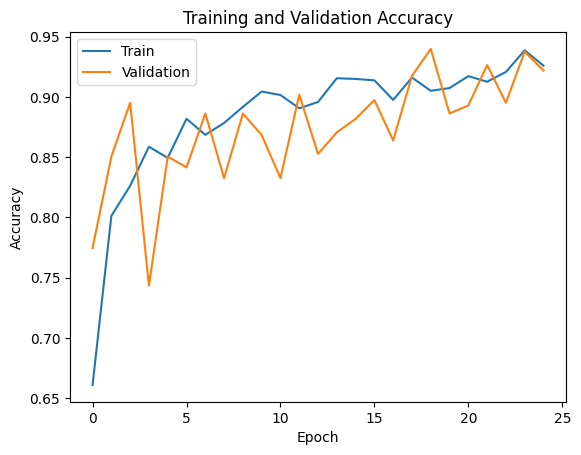

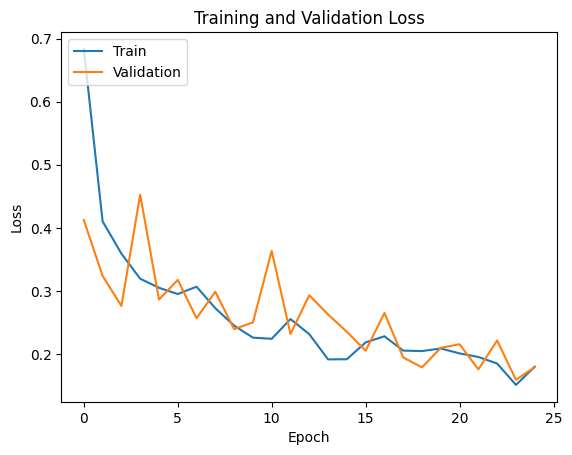

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show() #Melihat Grafik terkait dengan perkembangan loss dan akurasi dari data training dan validate

In [ ]:
acneModel.save('/content/drive/My Drive/AiCNE_FIX.keras')